In [1]:
import numpy as np
from cmath import * 
import torch
import pickle
import os
from time import time 
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from termcolor import colored
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
strikes = np.arange(0.5,1.6,0.1)
maturities = np.array([0.1,0.3,0.6,0.9,1.2,1.5,1.8,2])
S0=1

In [3]:
# Fully connected Neural Network with:

    # Elu activation (alpha=?)
    # 3 hidden Layers
    # 30 nodes

hidden_dim = 30
input_dim = 4 # xi, nu, rho, H 
output_dim = 11*8 # 11x8 IV surface
learning_rate=0.005

class NN_CAL(nn.Module):
    def __init__(self):
        
        super(NN_CAL, self).__init__()
        
        self.conv2D_1 = nn.Conv2d(1, 16, 3)
        self.Maxpool_1 = nn.MaxPool2d(2, 2)
        self.L1 = nn.Linear(16 * 4 * 3, 50)
        self.L2 = nn.Linear(50, 4)
    
    

        self.elu = nn.ELU(alpha=1, inplace=False)
        
        for name, param in self.conv2D_1.named_parameters():
            if 'weight' in name:
                nn.init.xavier_normal_(param)
        for name, param in self.Maxpool_1.named_parameters():
            if 'weight' in name:
                nn.init.xavier_normal_(param)  
        for name, param in self.L1.named_parameters():
            if 'weight' in name:
                nn.init.xavier_uniform_(param) 
        for name, param in self.L2.named_parameters():
            if 'weight' in name:
                nn.init.xavier_uniform_(param) 
        
        
    def forward(self, iv_surface): # [ Batch_size , 1, 11, 8] 
                              
        conv = self.conv2D_1(iv_surface) #[ Batch_size , 16, 9, 6]

        activation1 = self.elu(conv) 

        maxpool = self.Maxpool_1(activation1)   #[Batch_size, 16, 4, 3]
                
        maxpool = maxpool.view(-1, 16 * 4 * 3) # [Batch_size, 16 * 4 * 3]
        
        lin1 = self.L1(maxpool)    # [Batch_size, 50]

        activation2 = self.elu(lin1)

        output = self.L2(activation2) # [Batch_size,  4 ]

        
        return output

In [4]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [5]:

# Model summary
NN_cal = NN_CAL()
print(NN_cal)
print("Number of parameters", count_parameters(NN_CAL()) )

NN_CAL(
  (conv2D_1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
  (Maxpool_1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (L1): Linear(in_features=192, out_features=50, bias=True)
  (L2): Linear(in_features=50, out_features=4, bias=True)
  (elu): ELU(alpha=1)
)
Number of parameters 10014


In [6]:
# Data importation

import gzip
f = gzip.GzipFile('rBergomiTrainSet.txt.gz', "r")
dat=np.load(f)

model_parameters=dat[:,:4]
implied_vols=dat[:,4:]




In [7]:
# Normalization
mean_data = np.mean(implied_vols, axis = 0)
std_data = np.std(implied_vols, axis = 0)

implied_vols_N = (implied_vols - mean_data)/std_data


In [8]:
# Split training and test

implied_vols_training =  torch.Tensor(implied_vols_N[:33792,:])
model_parameters_training =  torch.Tensor(model_parameters[:33792,:])

implied_vols_test =  torch.Tensor(implied_vols_N[34000:,:])
model_parameters_test =  torch.Tensor(model_parameters[34000:,:])

XI_test = model_parameters[34000:,0]
NU_test = model_parameters[34000:,1]
RHO_test = model_parameters[34000:,2]
H_test = model_parameters[34000:,3]

In [9]:
def shuffle_batch(in_sample, out_sample, batch_size):
    rnd_idx = np.random.permutation(in_sample.shape[0])
    in_sample_batch = []
    out_sample_batch = []
    n_batches = in_sample.shape[0] // batch_size
    
    for batch_idx in np.array_split(rnd_idx, n_batches):
        in_sample_batch.append(in_sample[batch_idx,:])
        out_sample_batch.append(out_sample[batch_idx,:])
        
    return ( (in_sample_batch, out_sample_batch) )


In [10]:
# Training setting 

learning_rate = 0.005
batch_size = 128
epochs = 400
nb_batch = model_parameters_training.shape[0]//batch_size #nb of patch / set
optimizer = torch.optim.Adam(NN_cal.parameters(), lr=learning_rate)
loss = nn.MSELoss()

In [11]:
min_loss = 10
LOSS_B = []
LOSS_test = []
training_rates = [learning_rate]
NN_cal_model_File = "NN_cal_TEST_DATA_model.pkl" 


In [12]:
# Rate decay
tau = epochs
min_rate = 0.01*learning_rate #Cf deep learning Chap 8 p310

In [13]:
def vector(matrix):
    x = matrix[:,0,:]
    for i in range(1,matrix.shape[1]):
        x = torch.cat((x,matrix[:,i,:]), dim=1)
    return(x)

def matrix(vector,rows,colums):
    x = torch.zeros((vector.shape[0],rows,colums))
    for i in range(vector.shape[0]):
        for j in range(rows):
            x[i,j,:] = vector[i,j*colums:(j+1)*colums]
    return(x)


In [14]:
implied_vols_test = torch.reshape(matrix(implied_vols_test, 8, 11), (implied_vols_test.shape[0],11,8) )

Learning Rate 0.005
Epoch: 0 loss: 0.035727888345718384
Best Loss 0.035727888345718384
Best Batch Loss tensor(0.0046, grad_fn=<MseLossBackward>) 

TEST
Min Test Loss tensor(0.0063, grad_fn=<MseLossBackward>)
('Quadratic loss ', 0.006260181311517954)
Learning Rate 0.005
Epoch: 1 loss: 0.005326916463673115
Best Loss 0.005326916463673115
Best Batch Loss tensor(0.0032, grad_fn=<MseLossBackward>) 

TEST
Min Test Loss tensor(0.0051, grad_fn=<MseLossBackward>)
('Quadratic loss ', 0.005072787404060364)
Learning Rate 0.004987625000000001
Epoch: 2 loss: 0.003115632338449359
Best Loss 0.003115632338449359
Best Batch Loss tensor(0.0018, grad_fn=<MseLossBackward>) 

TEST
Min Test Loss tensor(0.0022, grad_fn=<MseLossBackward>)
('Quadratic loss ', 0.002155159367248416)
Learning Rate 0.0049752500000000005
Epoch: 3 loss: 0.0020549206528812647
Best Loss 0.0020549206528812647
Best Batch Loss tensor(0.0012, grad_fn=<MseLossBackward>) 

TEST
Min Test Loss tensor(0.0015, grad_fn=<MseLossBackward>)
('Quadrat

TEST
Min Test Loss tensor(0.0003, grad_fn=<MseLossBackward>)
('Quadratic loss ', 0.0002808709105011076)
Learning Rate 0.004665875
Epoch: 28 loss: 0.00035905567347072065
Best Loss 0.00035905567347072065
Best Batch Loss tensor(0.0001, grad_fn=<MseLossBackward>) 

TEST
Min Test Loss tensor(0.0003, grad_fn=<MseLossBackward>)
('Quadratic loss ', 0.0006729636806994677)
Learning Rate 0.0046535
Epoch: 29 loss: 0.0003806190798059106
Best Loss 0.00035905567347072065
Best Batch Loss tensor(0.0001, grad_fn=<MseLossBackward>) 

TEST
Min Test Loss tensor(0.0002, grad_fn=<MseLossBackward>)
('Quadratic loss ', 0.0002381554659223184)
Learning Rate 0.004641125
Epoch: 30 loss: 0.00036935193929821253
Best Loss 0.00035905567347072065
Best Batch Loss tensor(0.0001, grad_fn=<MseLossBackward>) 

TEST
Min Test Loss tensor(0.0002, grad_fn=<MseLossBackward>)
('Quadratic loss ', 0.00029967320733703673)
Learning Rate 0.004628750000000001
Epoch: 31 loss: 0.0003266408748459071
Best Loss 0.0003266408748459071
Best Ba

Learning Rate 0.00433175
Epoch: 55 loss: 0.0002598788123577833
Best Loss 0.00016434404824394733
Best Batch Loss tensor(6.7687e-05, grad_fn=<MseLossBackward>) 

TEST
Min Test Loss tensor(0.0001, grad_fn=<MseLossBackward>)
('Quadratic loss ', 0.00013394170673564076)
Learning Rate 0.004319375
Epoch: 56 loss: 0.00018641566566657275
Best Loss 0.00016434404824394733
Best Batch Loss tensor(6.7687e-05, grad_fn=<MseLossBackward>) 

TEST
Min Test Loss tensor(0.0001, grad_fn=<MseLossBackward>)
('Quadratic loss ', 0.00011906294821528718)
Learning Rate 0.004307
Epoch: 57 loss: 0.00014570419443771243
Best Loss 0.00014570419443771243
Best Batch Loss tensor(6.7687e-05, grad_fn=<MseLossBackward>) 

TEST
Min Test Loss tensor(0.0001, grad_fn=<MseLossBackward>)
('Quadratic loss ', 0.00012503910693340003)
Learning Rate 0.004294625000000001
Epoch: 58 loss: 0.00019407054060138762
Best Loss 0.00014570419443771243
Best Batch Loss tensor(6.4744e-05, grad_fn=<MseLossBackward>) 

TEST
Min Test Loss tensor(8.3040e

Learning Rate 0.0039976249999999994
Epoch: 82 loss: 0.00012479910219553858
Best Loss 0.00011264814384048805
Best Batch Loss tensor(3.0889e-05, grad_fn=<MseLossBackward>) 

TEST
Min Test Loss tensor(7.7564e-05, grad_fn=<MseLossBackward>)
('Quadratic loss ', 8.864723349688575e-05)
Learning Rate 0.00398525
Epoch: 83 loss: 0.00018073210958391428
Best Loss 0.00011264814384048805
Best Batch Loss tensor(3.0889e-05, grad_fn=<MseLossBackward>) 

TEST
Min Test Loss tensor(7.7564e-05, grad_fn=<MseLossBackward>)
('Quadratic loss ', 0.00015516896382905543)
Learning Rate 0.003972875
Epoch: 84 loss: 0.00011033200280508026
Best Loss 0.00011033200280508026
Best Batch Loss tensor(3.0889e-05, grad_fn=<MseLossBackward>) 

TEST
Min Test Loss tensor(7.6320e-05, grad_fn=<MseLossBackward>)
('Quadratic loss ', 7.631996413692832e-05)
Learning Rate 0.0039605000000000005
Epoch: 85 loss: 0.00014255598944146186
Best Loss 0.00011033200280508026
Best Batch Loss tensor(3.0889e-05, grad_fn=<MseLossBackward>) 

TEST
Min

Learning Rate 0.0036635
Epoch: 109 loss: 8.744148362893611e-05
Best Loss 7.44407152524218e-05
Best Batch Loss tensor(2.7980e-05, grad_fn=<MseLossBackward>) 

TEST
Min Test Loss tensor(5.3475e-05, grad_fn=<MseLossBackward>)
('Quadratic loss ', 0.0001406745723215863)
Learning Rate 0.0036511250000000003
Epoch: 110 loss: 0.00012791242625098675
Best Loss 7.44407152524218e-05
Best Batch Loss tensor(2.7980e-05, grad_fn=<MseLossBackward>) 

TEST
Min Test Loss tensor(5.3475e-05, grad_fn=<MseLossBackward>)
('Quadratic loss ', 0.00010598496737657115)
Learning Rate 0.0036387499999999996
Epoch: 111 loss: 7.715748506598175e-05
Best Loss 7.44407152524218e-05
Best Batch Loss tensor(2.7980e-05, grad_fn=<MseLossBackward>) 

TEST
Min Test Loss tensor(5.3475e-05, grad_fn=<MseLossBackward>)
('Quadratic loss ', 0.00012649102427531034)
Learning Rate 0.003626375
Epoch: 112 loss: 8.759176853345707e-05
Best Loss 7.44407152524218e-05
Best Batch Loss tensor(2.7980e-05, grad_fn=<MseLossBackward>) 

TEST
Min Test L

Learning Rate 0.003329375
Epoch: 136 loss: 6.36617187410593e-05
Best Loss 5.6724133173702285e-05
Best Batch Loss tensor(2.7980e-05, grad_fn=<MseLossBackward>) 

TEST
Min Test Loss tensor(4.1078e-05, grad_fn=<MseLossBackward>)
('Quadratic loss ', 6.952546391403303e-05)
Learning Rate 0.0033169999999999996
Epoch: 137 loss: 7.648918108316138e-05
Best Loss 5.6724133173702285e-05
Best Batch Loss tensor(2.3053e-05, grad_fn=<MseLossBackward>) 

TEST
Min Test Loss tensor(4.1078e-05, grad_fn=<MseLossBackward>)
('Quadratic loss ', 6.868276977911592e-05)
Learning Rate 0.0033046250000000003
Epoch: 138 loss: 7.543487299699336e-05
Best Loss 5.6724133173702285e-05
Best Batch Loss tensor(2.3053e-05, grad_fn=<MseLossBackward>) 

TEST
Min Test Loss tensor(4.1078e-05, grad_fn=<MseLossBackward>)
('Quadratic loss ', 9.607349056750536e-05)
Learning Rate 0.00329225
Epoch: 139 loss: 6.716189091093838e-05
Best Loss 5.6724133173702285e-05
Best Batch Loss tensor(2.3053e-05, grad_fn=<MseLossBackward>) 

TEST
Min T

Learning Rate 0.0029952499999999996
Epoch: 163 loss: 5.912885899306275e-05
Best Loss 5.525951200979762e-05
Best Batch Loss tensor(2.1436e-05, grad_fn=<MseLossBackward>) 

TEST
Min Test Loss tensor(2.9698e-05, grad_fn=<MseLossBackward>)
('Quadratic loss ', 3.661808295873925e-05)
Learning Rate 0.0029828750000000003
Epoch: 164 loss: 6.670345464954153e-05
Best Loss 5.525951200979762e-05
Best Batch Loss tensor(2.1436e-05, grad_fn=<MseLossBackward>) 

TEST
Min Test Loss tensor(2.9698e-05, grad_fn=<MseLossBackward>)
('Quadratic loss ', 8.043929119594395e-05)
Learning Rate 0.0029705000000000005
Epoch: 165 loss: 6.652166484855115e-05
Best Loss 5.525951200979762e-05
Best Batch Loss tensor(2.1436e-05, grad_fn=<MseLossBackward>) 

TEST
Min Test Loss tensor(2.9698e-05, grad_fn=<MseLossBackward>)
('Quadratic loss ', 5.055263318354264e-05)
Learning Rate 0.002958125
Epoch: 166 loss: 4.897929829894565e-05
Best Loss 4.897929829894565e-05
Best Batch Loss tensor(2.1436e-05, grad_fn=<MseLossBackward>) 

TE

Learning Rate 0.0026611250000000007
Epoch: 190 loss: 5.0786344218067825e-05
Best Loss 4.267595068085939e-05
Best Batch Loss tensor(1.9716e-05, grad_fn=<MseLossBackward>) 

TEST
Min Test Loss tensor(2.9698e-05, grad_fn=<MseLossBackward>)
('Quadratic loss ', 4.4083029933972284e-05)
Learning Rate 0.00264875
Epoch: 191 loss: 5.177648927201517e-05
Best Loss 4.267595068085939e-05
Best Batch Loss tensor(1.9716e-05, grad_fn=<MseLossBackward>) 

TEST
Min Test Loss tensor(2.9698e-05, grad_fn=<MseLossBackward>)
('Quadratic loss ', 5.614127803710289e-05)
Learning Rate 0.002636375
Epoch: 192 loss: 6.059815495973453e-05
Best Loss 4.267595068085939e-05
Best Batch Loss tensor(1.9716e-05, grad_fn=<MseLossBackward>) 

TEST
Min Test Loss tensor(2.9698e-05, grad_fn=<MseLossBackward>)
('Quadratic loss ', 5.684819188900292e-05)
Learning Rate 0.0026240000000000005
Epoch: 193 loss: 5.4938886023592204e-05
Best Loss 4.267595068085939e-05
Best Batch Loss tensor(1.9716e-05, grad_fn=<MseLossBackward>) 

TEST
Min T

Learning Rate 0.002327
Epoch: 217 loss: 3.5873239539796486e-05
Best Loss 3.5873239539796486e-05
Best Batch Loss tensor(1.5390e-05, grad_fn=<MseLossBackward>) 

TEST
Min Test Loss tensor(2.8496e-05, grad_fn=<MseLossBackward>)
('Quadratic loss ', 4.3702315451810136e-05)
Learning Rate 0.002314625
Epoch: 218 loss: 4.0604572859592736e-05
Best Loss 3.5873239539796486e-05
Best Batch Loss tensor(1.5390e-05, grad_fn=<MseLossBackward>) 

TEST
Min Test Loss tensor(2.8496e-05, grad_fn=<MseLossBackward>)
('Quadratic loss ', 4.612076372723095e-05)
Learning Rate 0.0023022499999999996
Epoch: 219 loss: 4.351396637503058e-05
Best Loss 3.5873239539796486e-05
Best Batch Loss tensor(1.5390e-05, grad_fn=<MseLossBackward>) 

TEST
Min Test Loss tensor(2.8496e-05, grad_fn=<MseLossBackward>)
('Quadratic loss ', 4.883700967184268e-05)
Learning Rate 0.0022898750000000002
Epoch: 220 loss: 5.391260128817521e-05
Best Loss 3.5873239539796486e-05
Best Batch Loss tensor(1.5390e-05, grad_fn=<MseLossBackward>) 

TEST
Min

Learning Rate 0.001992875
Epoch: 244 loss: 3.822493818006478e-05
Best Loss 3.183207081747241e-05
Best Batch Loss tensor(1.3982e-05, grad_fn=<MseLossBackward>) 

TEST
Min Test Loss tensor(2.6383e-05, grad_fn=<MseLossBackward>)
('Quadratic loss ', 7.354728586506099e-05)
Learning Rate 0.0019805
Epoch: 245 loss: 3.88432017643936e-05
Best Loss 3.183207081747241e-05
Best Batch Loss tensor(1.3982e-05, grad_fn=<MseLossBackward>) 

TEST
Min Test Loss tensor(2.6383e-05, grad_fn=<MseLossBackward>)
('Quadratic loss ', 9.27077344385907e-05)
Learning Rate 0.001968125
Epoch: 246 loss: 3.640643262770027e-05
Best Loss 3.183207081747241e-05
Best Batch Loss tensor(1.3982e-05, grad_fn=<MseLossBackward>) 

TEST
Min Test Loss tensor(2.6383e-05, grad_fn=<MseLossBackward>)
('Quadratic loss ', 2.7712956580216996e-05)
Learning Rate 0.00195575
Epoch: 247 loss: 3.290615859441459e-05
Best Loss 3.183207081747241e-05
Best Batch Loss tensor(1.3982e-05, grad_fn=<MseLossBackward>) 

TEST
Min Test Loss tensor(2.6383e-05

Learning Rate 0.0016587499999999996
Epoch: 271 loss: 2.8048008971381932e-05
Best Loss 2.704241887840908e-05
Best Batch Loss tensor(1.2274e-05, grad_fn=<MseLossBackward>) 

TEST
Min Test Loss tensor(2.2503e-05, grad_fn=<MseLossBackward>)
('Quadratic loss ', 3.453766112215817e-05)
Learning Rate 0.001646375
Epoch: 272 loss: 2.8373755412758328e-05
Best Loss 2.704241887840908e-05
Best Batch Loss tensor(1.2274e-05, grad_fn=<MseLossBackward>) 

TEST
Min Test Loss tensor(2.2503e-05, grad_fn=<MseLossBackward>)
('Quadratic loss ', 2.5038580133696087e-05)
Learning Rate 0.0016339999999999998
Epoch: 273 loss: 3.169446063111536e-05
Best Loss 2.704241887840908e-05
Best Batch Loss tensor(1.2274e-05, grad_fn=<MseLossBackward>) 

TEST
Min Test Loss tensor(2.2503e-05, grad_fn=<MseLossBackward>)
('Quadratic loss ', 3.7396486732177436e-05)
Learning Rate 0.0016216250000000002
Epoch: 274 loss: 3.259752702433616e-05
Best Loss 2.704241887840908e-05
Best Batch Loss tensor(1.2274e-05, grad_fn=<MseLossBackward>) 

Learning Rate 0.0013246249999999998
Epoch: 298 loss: 2.2695554434903897e-05
Best Loss 2.2695554434903897e-05
Best Batch Loss tensor(1.0399e-05, grad_fn=<MseLossBackward>) 

TEST
Min Test Loss tensor(1.4235e-05, grad_fn=<MseLossBackward>)
('Quadratic loss ', 2.936527380370535e-05)
Learning Rate 0.00131225
Epoch: 299 loss: 2.6963791242451407e-05
Best Loss 2.2695554434903897e-05
Best Batch Loss tensor(1.0399e-05, grad_fn=<MseLossBackward>) 

TEST
Min Test Loss tensor(1.4235e-05, grad_fn=<MseLossBackward>)
('Quadratic loss ', 2.05326359719038e-05)
Learning Rate 0.0012998749999999998
Epoch: 300 loss: 2.2879761672811583e-05
Best Loss 2.2695554434903897e-05
Best Batch Loss tensor(1.0399e-05, grad_fn=<MseLossBackward>) 

TEST
Min Test Loss tensor(1.4235e-05, grad_fn=<MseLossBackward>)
('Quadratic loss ', 1.6555266483919695e-05)
Learning Rate 0.0012875
Epoch: 301 loss: 2.250895522593055e-05
Best Loss 2.250895522593055e-05
Best Batch Loss tensor(1.0399e-05, grad_fn=<MseLossBackward>) 

TEST
Min 

Learning Rate 0.0009904999999999998
Epoch: 325 loss: 1.8009830455412157e-05
Best Loss 1.7707769075059332e-05
Best Batch Loss tensor(9.4125e-06, grad_fn=<MseLossBackward>) 

TEST
Min Test Loss tensor(1.4158e-05, grad_fn=<MseLossBackward>)
('Quadratic loss ', 1.9765288016060367e-05)
Learning Rate 0.000978125
Epoch: 326 loss: 1.769687150954269e-05
Best Loss 1.769687150954269e-05
Best Batch Loss tensor(9.4125e-06, grad_fn=<MseLossBackward>) 

TEST
Min Test Loss tensor(1.4158e-05, grad_fn=<MseLossBackward>)
('Quadratic loss ', 1.6535848772036843e-05)
Learning Rate 0.0009657500000000002
Epoch: 327 loss: 1.7952816051547416e-05
Best Loss 1.769687150954269e-05
Best Batch Loss tensor(9.0946e-06, grad_fn=<MseLossBackward>) 

TEST
Min Test Loss tensor(1.4158e-05, grad_fn=<MseLossBackward>)
('Quadratic loss ', 1.7627848137635738e-05)
Learning Rate 0.000953375
Epoch: 328 loss: 1.9341705410624854e-05
Best Loss 1.769687150954269e-05
Best Batch Loss tensor(9.0946e-06, grad_fn=<MseLossBackward>) 

TEST


Learning Rate 0.00066875
Epoch: 351 loss: 1.491517286922317e-05
Best Loss 1.4004862350702751e-05
Best Batch Loss tensor(6.7096e-06, grad_fn=<MseLossBackward>) 

TEST
Min Test Loss tensor(1.3400e-05, grad_fn=<MseLossBackward>)
('Quadratic loss ', 1.557225732540246e-05)
Learning Rate 0.0006563750000000003
Epoch: 352 loss: 1.4641037523688283e-05
Best Loss 1.4004862350702751e-05
Best Batch Loss tensor(6.7096e-06, grad_fn=<MseLossBackward>) 

TEST
Min Test Loss tensor(1.3400e-05, grad_fn=<MseLossBackward>)
('Quadratic loss ', 1.515642179583665e-05)
Learning Rate 0.0006439999999999999
Epoch: 353 loss: 1.3697340364160482e-05
Best Loss 1.3697340364160482e-05
Best Batch Loss tensor(6.7096e-06, grad_fn=<MseLossBackward>) 

TEST
Min Test Loss tensor(1.3400e-05, grad_fn=<MseLossBackward>)
('Quadratic loss ', 1.3402387594396714e-05)
Learning Rate 0.0006316250000000002
Epoch: 354 loss: 1.4212499991117511e-05
Best Loss 1.3697340364160482e-05
Best Batch Loss tensor(6.7096e-06, grad_fn=<MseLossBackward

Learning Rate 0.0003470000000000003
Epoch: 377 loss: 1.1426353921706323e-05
Best Loss 1.1426353921706323e-05
Best Batch Loss tensor(6.7096e-06, grad_fn=<MseLossBackward>) 

TEST
Min Test Loss tensor(1.1065e-05, grad_fn=<MseLossBackward>)
('Quadratic loss ', 1.3335848962015007e-05)
Learning Rate 0.000334625
Epoch: 378 loss: 1.1170766811119393e-05
Best Loss 1.1170766811119393e-05
Best Batch Loss tensor(6.7096e-06, grad_fn=<MseLossBackward>) 

TEST
Min Test Loss tensor(1.1065e-05, grad_fn=<MseLossBackward>)
('Quadratic loss ', 1.1487803021736909e-05)
Learning Rate 0.0003222500000000002
Epoch: 379 loss: 1.1118320799141657e-05
Best Loss 1.1118320799141657e-05
Best Batch Loss tensor(6.7096e-06, grad_fn=<MseLossBackward>) 

TEST
Min Test Loss tensor(1.1065e-05, grad_fn=<MseLossBackward>)
('Quadratic loss ', 1.1875811651407275e-05)
Learning Rate 0.000309875
Epoch: 380 loss: 1.0914708582276944e-05
Best Loss 1.0914708582276944e-05
Best Batch Loss tensor(6.7096e-06, grad_fn=<MseLossBackward>) 

T

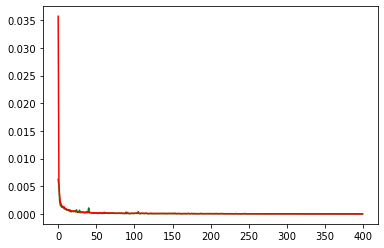

Learning Rates


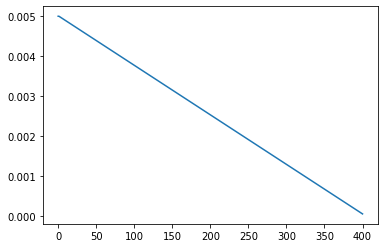

In [15]:
## Training

t1 = time()

for epoch in range(epochs):
    
    loss_b = 0
    
    in_sample_batch, out_sample_batch = shuffle_batch(model_parameters_training, implied_vols_training, batch_size)
    
    for in_sample, out_sample in zip(in_sample_batch, out_sample_batch) :

        optimizer.zero_grad()
        
        out_sample = torch.reshape(matrix(out_sample, 8,11),(batch_size, 11, 8) )
        out_sample = torch.reshape( out_sample , (batch_size, 1, 11,8 ) )

        output = NN_cal(out_sample)
        
        loss_batch = loss(output,in_sample)

        loss_b += loss_batch/nb_batch    
        
        loss_batch.backward()
        optimizer.step()
    
        min_loss = min(min_loss,loss_batch)
      
    LOSS_B.append(loss_b.item())
  
    print("Learning Rate", training_rates[-1] )
    print(colored("Epoch:",'red'), epoch,"loss:", colored(loss_b.item(),'red') )
    print( "Best Loss", min(LOSS_B))
    print('Best Batch Loss',min_loss , '\n')
    
    
    output = NN_cal( torch.reshape( implied_vols_test , (implied_vols_test.shape[0], 1, 11, 8 ) ) )
    
    test = loss(output,model_parameters_test)
    LOSS_test.append(test)
    
    if (test<=min(LOSS_test)):
        with open(NN_cal_model_File, 'wb') as file:  
            pickle.dump(NN_cal, file)      
    
    quadra = ("Quadratic loss ", test.item())
    print(colored("TEST",'green') )
    print("Min Test Loss", min(LOSS_test))
    print(colored(quadra,'green')) 
    
    
    if (epoch<tau):
        rate = (1-(epoch/tau))*learning_rate + (epoch/tau)*min_rate # Cf deep learning Chap 8 p310
        optimizer.param_groups[0]['lr'] = rate
        training_rates.append(rate)
        #NN_cal.elu = nn.ELU(alpha = rate, inplace=False)
      
    else:
        rate = min_rate # Cf deep learning Chap 8 p310
        optimizer.param_groups[0]['lr'] = rate
        training_rates.append(rate)
        #NN_cal.elu = nn.ELU(alpha = rate, inplace=False)
    
t2 = time()

print( colored('Finale Validation Loss','red') , colored(loss_b.item(),'red'))
print( colored('Best Validation Loss', 'green'), min(LOSS_B))
print(colored('Finale Test Loss', 'red'), LOSS_test[-1])
print(colored('Best Test Loss', 'green' ), min(LOSS_test) )
print('Data Size', model_parameters_training.shape)
print("Training Time (h)", (t2-t1)/3600 ,'\n') 

print( "Evolution during training")


print( "Quadratic loss evolution")
plt.plot(LOSS_test,color='green')
plt.plot(LOSS_B,color='red')
plt.show()

print("Learning Rates")
plt.plot(training_rates)
plt.show()

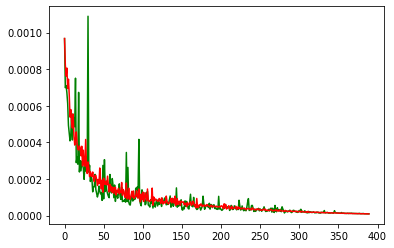

In [16]:
plt.plot(LOSS_test[10:],color='green')
plt.plot(LOSS_B[10:],color='red')
plt.show()

In [17]:
def surface_plot (matrix, **kwargs):
    (x, y) = np.meshgrid(strikes,maturities)
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    surf = ax.plot_surface(x, y, matrix, **kwargs)
    return (fig, ax, surf)

def average_RE(pred, true):
    return (torch.mean( abs(pred-true)/abs(true) , dim=0))

def RE(pred,true):
    return( abs(pred-true)/abs(true) )

def std_RE(pred, true):
    return (torch.std( abs(pred-true)/abs(true) , dim=0) )

def max_RE(pred, true):
    return(torch.max( abs(pred-true)/abs(true) , dim=0)[0])

In [23]:
output = NN_cal( torch.reshape( implied_vols_test , (implied_vols_test.shape[0], 1, 11, 8 ) ) )


Av_RE = average_RE(output, model_parameters_test)
RE_ = RE(output, model_parameters_test)

print( 'Average relative error for all parameters ', torch.mean(Av_RE).item())


Average relative error for all parameters  0.007879579439759254


In [19]:
XI = model_parameters_test[:,0]
NU = model_parameters_test[:,1]
RHO = model_parameters_test[:,2]
H = model_parameters_test[:,3]


In [20]:
RE_xi = RE_[:,0]
RE_nu = RE_[:,1]
RE_rho = RE_[:,2]
RE_H = RE_[:,3]

In [24]:
(0.42+0.72+2.23+1.44)/4

1.2025000000000001

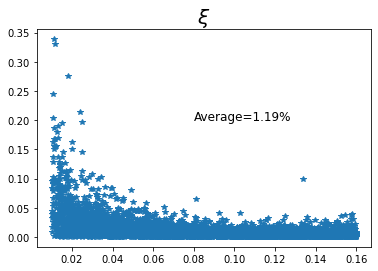

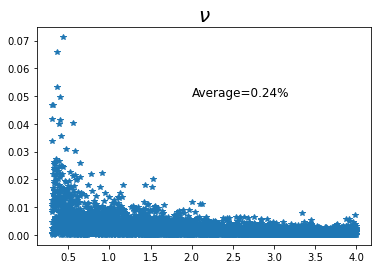

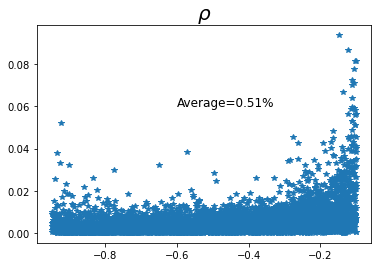

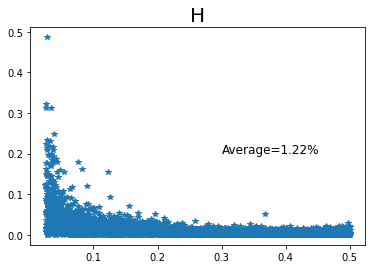

In [22]:
plt.title(r'$\xi$', fontsize = 20)
plt.text(0.08,0.2, 'Average='+str(np.round(Av_RE[0].item()*100,2))+'%', fontsize = 12)
plt.plot(XI,RE_xi.detach().numpy(), '*')
plt.show()


plt.title(r'$\nu$', fontsize = 20)
plt.text(2,0.05, 'Average='+str(np.round(Av_RE[1].item()*100,2))+'%', fontsize = 12)
plt.plot(NU,RE_nu.detach().numpy(), '*')
plt.show()

plt.title(r'$\rho$', fontsize = 20)
plt.text(-0.6,0.06, 'Average='+str(np.round(Av_RE[2].item()*100,2))+'%', fontsize = 12)
plt.plot(RHO,RE_rho.detach().numpy(), '*')
plt.show()


plt.title('H', fontsize = 20)
plt.text(0.3,0.2, 'Average='+str(np.round(Av_RE[3].item()*100,2))+'%', fontsize = 12)
plt.plot(H,RE_H.detach().numpy(), '*')
plt.show()